# Arbol de decisión

Se crea un arbol de decisón basandonos en las caracteristicas de la red neuronal

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
import numpy as np
from sklearn.preprocessing import StandardScaler

import ast

In [159]:
# Semilla
seed = 42

In [188]:
def paint_results(y_test, y_pred, order = True):
  # Grafica de la predicción y la realidad
  linespace = np.linspace(0, 1, y_pred.size)
  if order:
    # Ordena los pares test pred para que se vean mejor
    y_test, y_pred = zip(*sorted(zip(y_test, y_pred)))

  plt.plot(linespace, y_test, label="Real", marker="o")
  plt.plot(linespace, y_pred, label="Predicción", marker="x")
  plt.legend()
  plt.title("Real vs Predicción")
  plt.show()
  
def paint_real_vs_pred(y_test, y_pred):
  # Grafica de la predicción y la realidad
  plt.scatter(y_test, y_pred, marker="o")
  plt.xlabel("Real")
  plt.ylabel("Predicción")
  plt.title("Real vs Predicción")
  plt.show()

Mean Absolute Error:  0.16237486970424658
R2:  -0.943593240131738


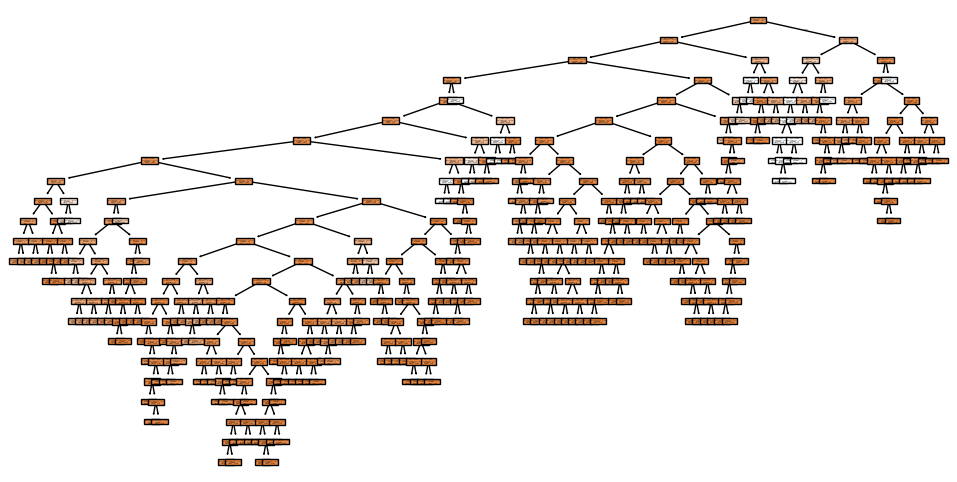

In [161]:
# lee el df
df = pd.read_csv("./results_transformed.csv")

# Definir variables
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["iou"]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Crear y entrenar arbol
model = DecisionTreeRegressor(random_state=seed)
regressor = model.fit(X_train, y_train)

# Predecir
y_pred = regressor.predict(X_test)

# Calcular error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

# Visualizar el árbol de decisión
plt.figure(figsize=(12, 6))
plot_tree(regressor, feature_names=X.columns, filled=True)
plt.show()

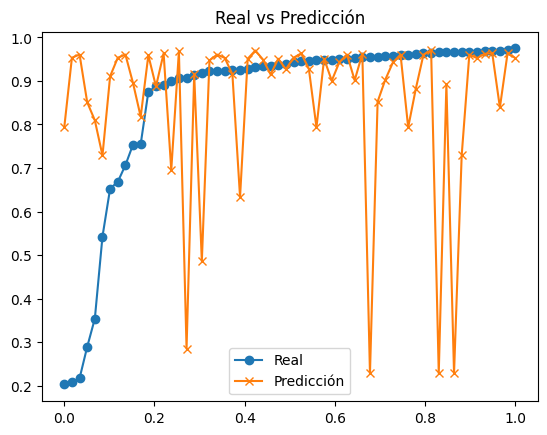

In [162]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)

# Bosques aleatorios

In [163]:
from sklearn.ensemble import RandomForestRegressor

In [164]:
# lee el df
df = pd.read_csv("./results_transformed.csv")

# Definir variables
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["iou"]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Crear y entrenar modelo
model = RandomForestRegressor(random_state=seed, n_estimators=100)

model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)

# Calcular error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

Mean Absolute Error:  0.1383930085589489
R2:  -0.044504158471702526


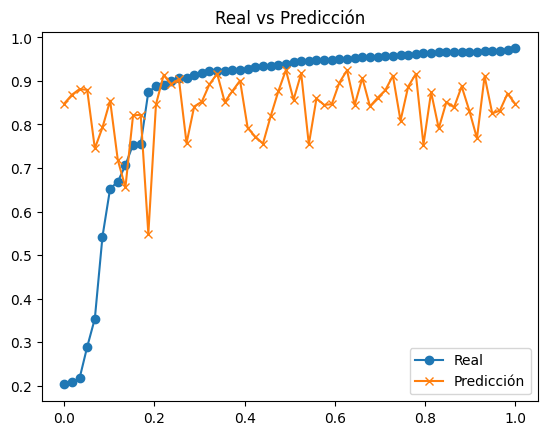

In [165]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)

# XGBRegressor

In [166]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Leer el DataFrame
df = pd.read_csv("./results_transformed.csv")

# Definir variables (expandir listas en columnas)
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["iou"]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Escalar características (opcional, XGBoost maneja datos sin escalar, pero ayuda en algunos casos)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Crear y entrenar el modelo XGBoost
model = XGBRegressor(
    n_estimators=100,      # Número de árboles (boosting rounds)
    learning_rate=0.01,     # Tasa de aprendizaje
    max_depth=3,           # Profundidad máxima de los árboles
    random_state=seed
)

model.fit(X_train_scaled, y_train)

# Predecir
y_pred = model.predict(X_test_scaled)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Absolute Error: 0.1322829246719678
R² Score: -0.03349812047234213


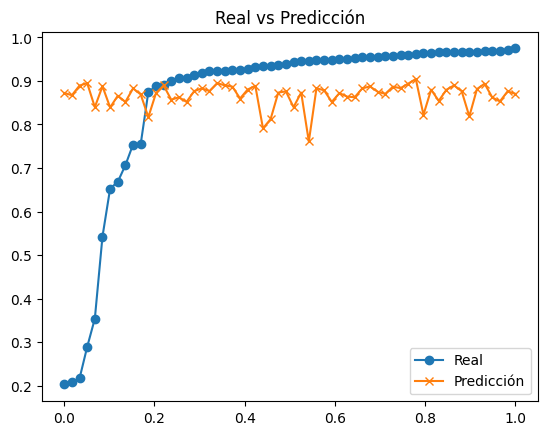

In [167]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)

# Perceptrón multicapa

In [192]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Definir la red neuronal corregida
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(62, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x) # No se aplica función de activación para regresión
        return x

# Leer y preparar los datos
df = pd.read_csv("./results_transformed.csv")
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series).to_numpy()
X = np.nan_to_num(X, nan=-1)  # Reemplazar NaN por -1
y = df["iou"].to_numpy()

# Escalar características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Inicializar modelo, pérdida y optimizador
model = RegressionNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reducir learning rate

# Entrenamiento
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:  # Mini-lotes
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {total_loss / len(train_loader)}")

# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}, R²: {r2:.4f}")

Epoch 0 - Loss: 0.7949161529541016
Epoch 10 - Loss: 0.05865501649677753
Epoch 20 - Loss: 0.03569044098258019
Epoch 30 - Loss: 0.026732068633039792
Epoch 40 - Loss: 0.02087242268025875
Epoch 50 - Loss: 0.016023564742257197
Epoch 60 - Loss: 0.012025447251896063
Epoch 70 - Loss: 0.008808348669360082
Epoch 80 - Loss: 0.006244412312904994
Epoch 90 - Loss: 0.004263474089869609
MAE: 0.1579, R²: -0.4022


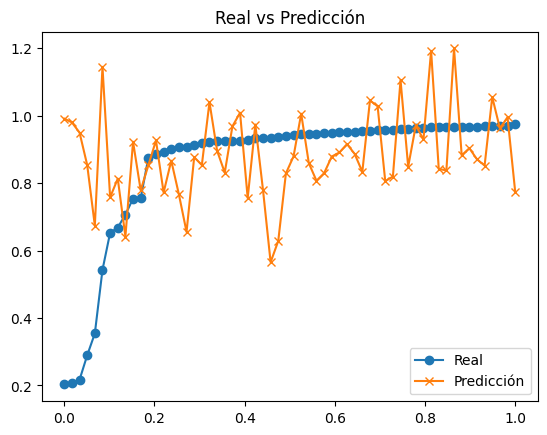

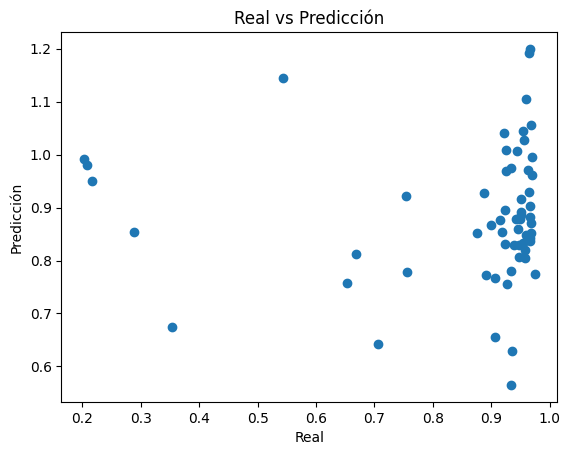

In [194]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)